# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the datasets
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [3]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [4]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [5]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [6]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [7]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']


In [9]:
X_train = np.expand_dims(X_train, axis=1)

In [8]:
# Create sequences
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

timesteps = 1

# Update X_train and y_train with sequences
X_train, y_train = create_sequences(X_train.values, y_train.values, timesteps)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (30675, 1, 9)
y_train shape: (30675,)


In [10]:
print(X_train.shape)
print(y_train.shape)

(30676, 1, 9)
(30676,)


In [10]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
# X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [9]:
# define model
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, dropout=0.2),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



c:\Users\user\time_series_forecasting\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    verbose=1,
    batch_size=32
)

Epoch 1/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 106.5342 - loss: 11869.5371
Epoch 2/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 98.5124 - loss: 9347.8066
Epoch 3/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 94.5736 - loss: 7952.4834
Epoch 4/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 91.6186 - loss: 6686.2900
Epoch 5/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 94.6277 - loss: 6501.1279
Epoch 6/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 95.9385 - loss: 6134.7661
Epoch 7/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 96.6343 - loss: 5847.8315
Epoch 8/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 97.5067 - loss: 5702.7573
Epoch 9/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 97.4721 - loss: 5478.1758
Epoch 10/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 99.2451 - loss: 5554.2812
Epoch 11/100
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 99.2009 - loss: 5383.8882
Epoch 12/100
959/

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


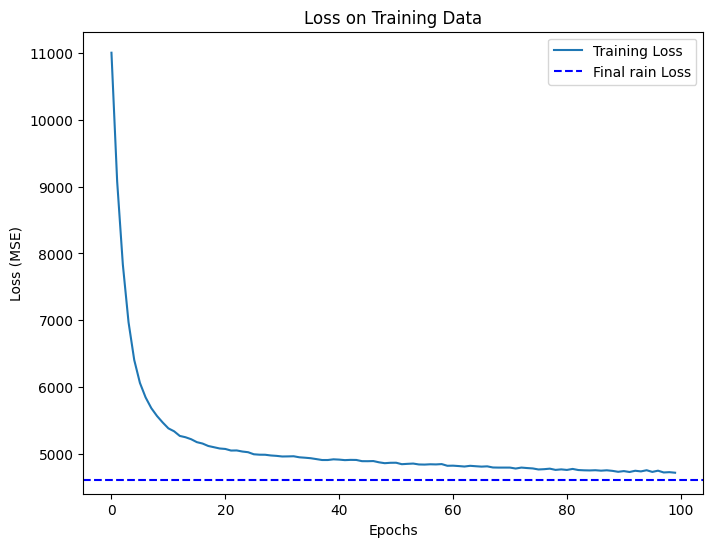

Final Training Loss (MSE): 4608.207483328819


In [12]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [13]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Preparing 'row ID' to remove leading zeros from hour
row_ids = [
    f"{ts.year:04d}-{ts.month:02d}-{ts.day:02d} {ts.hour}:{ts.minute:02d}:{ts.second:02d}"
    for ts in pd.to_datetime(test.index)
]

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': row_ids,
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('../data/predictions/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
